# Detecting Adverse Drug Events From Conversational Texts

Adverse Drug Events (ADEs) are potentially very dangerous to patients and are top causes of morbidity and mortality. Many ADEs are hard to discover as they happen to certain groups of people in certain conditions and they may take a long time to expose. Healthcare providers conduct clinical trials to discover ADEs before selling the products but normally are limited in numbers. Thus, post-market drug safety monitoring is required to help discover ADEs after the drugs are sold on the market. 

Less than 5% of ADEs are reported via official channels and the vast majority is described in free-text channels: emails & phone calls to patient support centers, social media posts, sales conversations between clinicians and pharma sales reps, online patient forums, and so on. This requires pharmaceuticals and drug safety groups to monitor and analyze unstructured medical text from a variety of jargons, formats, channels, and languages - with needs for timeliness and scale that require automation. 

Here we show how to use Spark NLP's existing models to process conversational text and extract highly specialized ADE and DRUG information that can be used for various downstream use cases, including;
<break>
- Conversational Texts ADE Classification
- Detecting ADE and Drug Entities From Texts
- Analysis of Drug and ADE Entities
- Finding Drugs and ADEs Have Been Talked Most
- Detecting Most Common Drug-ADE Pairs
- Checking Assertion Status of ADEs
- Relations Between ADEs and Drugs

**Initial Configurations**

In [0]:
from johnsnowlabs import nlp, medical

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
#nlp.install()

In [0]:
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pyspark.sql as SQL

import os
import json
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from pyspark.ml import Pipeline, PipelineModel

pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)  
pd.set_option('display.expand_frame_repr', False)

spark

Out[2]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.2 
 Master 
 spark://10.139.64.4:7077 
 AppName 
 Databricks Shell

## Download Dataset

We will use a slightly modified version of some conversational ADE texts which are downloaded from https://sites.google.com/site/adecorpus/home/document.

Also you can find an article about this dataset here: https://www.sciencedirect.com/science/article/pii/S1532046412000615

**We will work with two main files in the dataset:**

- ADE-AE.rel : Conversations with ADE.
- ADE-NEG.txt : Conversations with no ADE.

Lets get started with downloading these files.

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ADE_Corpus_V2/DRUG-AE.rel -P /dbfs/
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ADE_Corpus_V2/ADE-NEG.txt -P /dbfs/

Now we will create dataframes named `neg_df` with **ADE-Negative** conversations and `pos_df` with **ADE-Positive** conversations.

In [0]:
neg_df = spark.read.csv("/ADE-NEG.txt").select("_c0")\
                                       .withColumn("hash", F.hash("_c0"))\
                                       .orderBy("hash")

neg_df = neg_df.withColumn('text', F.split(neg_df["_c0"], 'NEG').getItem(1))\
               .withColumn("is_ADE", F.lit(False))\
               .drop_duplicates(["text"])\
               .withColumn("id", F.monotonically_increasing_id()).select("id", "text", "is_ADE")
              
display(neg_df.limit(10))

id,text,is_ADE
0,Two patients had clots in the pump.,false
1,They no longer need red cell transfusions and have had a normal Hb concentration and normal ferrokinetics.,false
2,Both patients experienced the onset of psychiatric symptoms as young adults,false
3,Range orders for the delivery of IV opioids give nurses the flexibility needed to treat patients' pain in a timely manner while allowing for differences in patient response to pain and to analgesia.,false
4,The liver had zolpidem present at a concentration of 4.74 microg/g,false
5,Very rarely,false
6,Chest roentgenogram showed infiltration in the left lung field,false
7,The total amount ingested range from 14.3 to 99.3 mg/kg (mean,false
8,The patient was discharged on the 8th postoperative week in good conditions.,false
9,His immune system at this time was almost completely depleted.,false


In [0]:
neg_df.count()

Out[5]: 15918

In [0]:
pos_df = spark.read.csv("/DRUG-AE.rel", sep="|", header=None).select("_c1")\
                                                             .withColumn("hash", F.hash("_c1"))\
                                                             .withColumnRenamed("_c1","text")\
                                                             .withColumn("is_ADE", F.lit(True))\
                                                             .orderBy("hash")

pos_df = pos_df.drop_duplicates(["text"]).withColumn("id", F.monotonically_increasing_id()).select("id", "text", "is_ADE")
display(pos_df.limit(10))

id,text,is_ADE
0,The authors report 2 cases of renal damage associated with lithium carbonate treatment.,true
1,Hepatic angiosarcoma occurring after cyclophosphamide therapy: case report and review of the literature.,true
2,TREATMENT/OUTCOME: Standard anti-tuberculosis therapy was administered but was complicated by interaction with cyclosporine and drug-induced cholestasis.,true
3,"Thus, an immunological mechanism might be involved in the mechanism of pirmenol-induced QT prolongation and T wave inversion on the electrocardiogram.",true
4,Contact dermatitis due to budesonide: report of five cases and review of the Japanese literature.,true
5,We report a case of acute generalized exanthematous pustulosis (AGEP) in a 50-year-old woman that was attributed to the ingestion of nimesulide.,true
6,Spindle coma in benzodiazepine toxicity: case report.,true
7,Ceftriaxone was approved in 1997 for the treatment of otitis media despite previous studies that documented an association of ceftriaxone with elevated hepato-biliary enzymes and transient biliary stasis.,true
8,Fibrosis of corpus cavernosum after intracavernous injection of phentolamine/papaverine.,true
9,Presented is a case of acute renal failure induced by acetazolamide therapy for glaucoma.,true


In [0]:
pos_df.count()

Out[7]: 4271

We will store these dataframes in delta-table.

In [0]:
delta_path='/FileStore/HLS/nlp/delta/jsl/'

neg_df.write.format('delta').mode('overwrite').save(f'{delta_path}/ADE/neg_df')
display(dbutils.fs.ls(f'{delta_path}/ADE/neg_df'))

path,name,size
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/neg_df/_delta_log/,_delta_log/,0
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/neg_df/part-00000-46e5822d-9e9a-4f01-8854-71d03984b2cf-c000.snappy.parquet,part-00000-46e5822d-9e9a-4f01-8854-71d03984b2cf-c000.snappy.parquet,996193
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/neg_df/part-00000-4ce45ae4-a422-4af8-a89c-6ca979ae5cc0-c000.snappy.parquet,part-00000-4ce45ae4-a422-4af8-a89c-6ca979ae5cc0-c000.snappy.parquet,997160
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/neg_df/part-00000-5e7d7ac2-3cca-4d3b-b959-d7ea5f849c27-c000.snappy.parquet,part-00000-5e7d7ac2-3cca-4d3b-b959-d7ea5f849c27-c000.snappy.parquet,996193
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/neg_df/part-00000-62d8f95f-9de8-49b3-8373-93cef5f56c98-c000.snappy.parquet,part-00000-62d8f95f-9de8-49b3-8373-93cef5f56c98-c000.snappy.parquet,997160
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/neg_df/part-00000-6d906b9f-920e-41cf-89af-b2116e3a48ef-c000.snappy.parquet,part-00000-6d906b9f-920e-41cf-89af-b2116e3a48ef-c000.snappy.parquet,996193
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/neg_df/part-00000-6dd2a5d7-9d5b-4c77-a149-fc5d22883154-c000.snappy.parquet,part-00000-6dd2a5d7-9d5b-4c77-a149-fc5d22883154-c000.snappy.parquet,810795
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/neg_df/part-00000-7d48dcfd-420f-4e9c-9d51-5be1f11e3672-c000.snappy.parquet,part-00000-7d48dcfd-420f-4e9c-9d51-5be1f11e3672-c000.snappy.parquet,996193
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/neg_df/part-00000-aaefa88e-6f65-41ef-8b8c-47c244bb4d5e-c000.snappy.parquet,part-00000-aaefa88e-6f65-41ef-8b8c-47c244bb4d5e-c000.snappy.parquet,997197
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/neg_df/part-00000-f06ac1cc-25cf-4904-8614-cacd57e70c5d-c000.snappy.parquet,part-00000-f06ac1cc-25cf-4904-8614-cacd57e70c5d-c000.snappy.parquet,997197


In [0]:
pos_df.write.format('delta').mode('overwrite').save(f'{delta_path}/ADE/pos_df')
display(dbutils.fs.ls(f'{delta_path}/ADE/pos_df'))

path,name,size
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/pos_df/_delta_log/,_delta_log/,0
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/pos_df/part-00000-17592798-04fd-4c03-8c39-891cd74d91a0-c000.snappy.parquet,part-00000-17592798-04fd-4c03-8c39-891cd74d91a0-c000.snappy.parquet,352760
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/pos_df/part-00000-19808cd0-643e-416e-8120-36f2ea14dbcc-c000.snappy.parquet,part-00000-19808cd0-643e-416e-8120-36f2ea14dbcc-c000.snappy.parquet,352896
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/pos_df/part-00000-1cb90c28-e879-4797-bb9b-0defc78a57ff-c000.snappy.parquet,part-00000-1cb90c28-e879-4797-bb9b-0defc78a57ff-c000.snappy.parquet,352896
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/pos_df/part-00000-44495266-b62f-43c7-af37-c99533ef0e1f-c000.snappy.parquet,part-00000-44495266-b62f-43c7-af37-c99533ef0e1f-c000.snappy.parquet,352797
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/pos_df/part-00000-d76ec28e-f777-444a-9d45-71d6260a3073-c000.snappy.parquet,part-00000-d76ec28e-f777-444a-9d45-71d6260a3073-c000.snappy.parquet,352758
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/pos_df/part-00000-ee1bc813-479e-40de-ab75-022a3335f75f-c000.snappy.parquet,part-00000-ee1bc813-479e-40de-ab75-022a3335f75f-c000.snappy.parquet,352896
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/pos_df/part-00000-f0ea680f-c647-4e59-81ae-b1f7029786f3-c000.snappy.parquet,part-00000-f0ea680f-c647-4e59-81ae-b1f7029786f3-c000.snappy.parquet,352896
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/pos_df/part-00000-f33d194b-227c-4d4d-99ae-0a45b024a9be-c000.snappy.parquet,part-00000-f33d194b-227c-4d4d-99ae-0a45b024a9be-c000.snappy.parquet,352797
dbfs:/FileStore/HLS/nlp/delta/jsl/ADE/pos_df/part-00000-fb7e5738-b3b6-4509-843f-b1b04b187a80-c000.snappy.parquet,part-00000-fb7e5738-b3b6-4509-843f-b1b04b187a80-c000.snappy.parquet,352760


# 1. Conversational ADE Classification

## 1.1 Use Case: Text Classification According To Contains ADE or Not

Now we will try to predict if a text contains ADE or not by using `classifierdl_ade_conversational_biobert`. For this, we will create a new dataframe merging all ADE negative and ADE positive texts and shuffle that.

In [0]:
sdf = neg_df.union(pos_df).drop("is_ADE").orderBy(F.rand(seed=42)).withColumn("id", F.monotonically_increasing_id())

display(sdf.limit(10))

id,text
0,CSF examination revealed an inflammatory profile.
1,"We report a case of generalized cutaneous sclerosis associated with muscle and oesophageal involvement in a patient exposed to herbicides containing bromocil, diuron and aminotriazole."
2,METHODS: This is a case of angiosarcoma developing 5 years after curative therapy for T3N0 squamous cell carcinoma of the supraglottic larynx.
3,"Two patients with ovarian cancer who had received multiple courses of cisplatin without complications experienced hypersensitivity reactions to cisplatin: one, involving intrahepatic artery infusion, manifested general erythema, dyspnea, and hypotension; the other, involving intravenous infusion, manifested abdominal pain, general erythema, and fever."
4,Evidence obtained indicated that the Reye-like syndrome might be caused by calcium hopantenate possibly due to the induction of pantothenic acid deficiency.
5,"The goal of this study is to describe three patients diagnosed with migraine and epilepsy (both under control) who evolved into status migrainosus after the introduction of oxcarbazepine (OXC), as part of a switch off from carbamazepine (CBZ)."
6,All 4 patients who were recruited completed the procedure successfully without significant difficulty.
7,Sensory neuropathy revealing necrotizing vasculitis during infliximab therapy for rheumatoid arthritis.
8,CONCLUSION: Copperhead bites typically result in mild to moderate envenomation due to local tissue effects.
9,A case of metoclopramide-induced oculogyric crisis in a 16-year-old girl with cystic fibrosis.


In [0]:
sdf = sdf.repartition(32)

In [0]:
document_assembler = nlp.DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

tokenizer = nlp.Tokenizer()\
        .setInputCols(['document'])\
        .setOutputCol('token')

embeddings = nlp.BertEmbeddings.pretrained('biobert_pubmed_base_cased')\
        .setInputCols(["document", 'token'])\
        .setOutputCol("embeddings")

sentence_embeddings = nlp.SentenceEmbeddings() \
        .setInputCols(["document", "embeddings"]) \
        .setOutputCol("sentence_embeddings") \
        .setPoolingStrategy("AVERAGE")

conv_classifier = nlp.ClassifierDLModel.pretrained('classifierdl_ade_conversational_biobert', 'en', 'clinical/models')\
        .setInputCols(['sentence_embeddings'])\
        .setOutputCol('conv_class')


clf_pipeline = nlp.Pipeline(stages=[
    document_assembler, 
    tokenizer, 
    embeddings, 
    sentence_embeddings, 
    conv_classifier])

empty_data = spark.createDataFrame([['']]).toDF("text")
clf_model = clf_pipeline.fit(empty_data)

biobert_pubmed_base_cased download started this may take some time.
Approximate size to download 386.4 MB
[ | ][OK!]
classifierdl_ade_conversational_biobert download started this may take some time.
Approximate size to download 21.8 MB
[ | ][ / ][ — ][OK!]

In [0]:
result = clf_model.transform(sdf)

Lets get the `classifierdl_ade_conversational_biobert` model results in `conv_cl_result` column.

In [0]:
 res_df = result.select("id", "text", F.explode(F.arrays_zip(result.conv_class.result)).alias("cols"))\
                .select("id", "text", F.expr("cols['0']").alias("conv_cl_result"))\
                .withColumn('conv_cl_result', F.col('conv_cl_result').cast('boolean'))

**Let's see the number of predictions on each class for the first 100 rows.**

In [0]:
display(
        res_df.limit(100)
              .groupBy("conv_cl_result")
              .count()
       )

conv_cl_result,count
false,81
true,19


**Lets check some of the example sentences that the model predicted the ADE is `True` and `False`.**

In [0]:
display(res_df.limit(20))

id,text,conv_cl_result
5154,"A case of sideroblastic anemia is presented in a patient with a left ventricular assist device drive-line infection who was receiving linezolid, an antibiotic used for serious infections with gram-positive organisms.",false
19622,Initiation of posaconazole led to clinical improvement until the patient's demise from bacteremic vancomycin-resistant enterococcal peritonitis.,false
16706,Laryngeal necrosis after combined chemotherapy and radiation therapy.,false
1423,The administration of amyl nitrite and sodium thiosulfate led to a rapid improvement: the parameters reflecting oxygen metabolism improved and the plasma level of cyanide decreased.,false
11748,For the most part these preparations have been considered safe.,false
3599,The patient was a borderline candidate for mechanical ventilation for 3 weeks.,false
12214,The episode appeared to have been precipitated by toxicity due to ingestion of a large amount of phenytoin.,true
13966,"A woman with a 20-year history of acral pustular psoriasis of Hallopeau and recurrent pustular lesions of the forearms and lower legs, developed a B-cell lymphoma of the lip following 4 1/2 years of treatment with razoxane.",true
974,A drug lymphocyte stimulation test was positive only for calcium stearate,false
18742,A case is described,false


# 2. ADE-DRUG NER Examination

We will work on `pos_df` dataframe from now.

In [0]:
df = spark.read.format('delta').load(f'{delta_path}/ADE/pos_df/').drop("is_ADE")
display(df.limit(10))

id,text
0,The authors report 2 cases of renal damage associated with lithium carbonate treatment.
1,Hepatic angiosarcoma occurring after cyclophosphamide therapy: case report and review of the literature.
2,TREATMENT/OUTCOME: Standard anti-tuberculosis therapy was administered but was complicated by interaction with cyclosporine and drug-induced cholestasis.
3,"Thus, an immunological mechanism might be involved in the mechanism of pirmenol-induced QT prolongation and T wave inversion on the electrocardiogram."
4,Contact dermatitis due to budesonide: report of five cases and review of the Japanese literature.
5,We report a case of acute generalized exanthematous pustulosis (AGEP) in a 50-year-old woman that was attributed to the ingestion of nimesulide.
6,Spindle coma in benzodiazepine toxicity: case report.
7,Ceftriaxone was approved in 1997 for the treatment of otitis media despite previous studies that documented an association of ceftriaxone with elevated hepato-biliary enzymes and transient biliary stasis.
8,Fibrosis of corpus cavernosum after intracavernous injection of phentolamine/papaverine.
9,Presented is a case of acute renal failure induced by acetazolamide therapy for glaucoma.


In [0]:
df.count()

Out[19]: 4271

In [0]:
df = df.repartition(32)

## 2.1. Use Case: Detecting ADE and Drug Entities From Texts

Now we will extract `ADE` and `DRUG` entities from the conversational texts by using a combination of `ner_ade_clinical` and `ner_posology` models.

In [0]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")
  
ade_ner = medical.NerModel.pretrained("ner_ade_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ade_ner")

ade_ner_converter = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "ade_ner"]) \
    .setOutputCol("ade_ner_chunk")\

pos_ner = medical.NerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("pos_ner")

pos_ner_converter = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "pos_ner"]) \
    .setOutputCol("pos_ner_chunk")\
    .setWhiteList(["DRUG"])

chunk_merger = medical.ChunkMergeApproach()\
    .setInputCols("ade_ner_chunk","pos_ner_chunk")\
    .setOutputCol("ner_chunk")\


ner_pipeline = nlp.Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    ade_ner,
    ade_ner_converter,
    pos_ner,
    pos_ner_converter,
    chunk_merger
    ])


empty_data = spark.createDataFrame([[""]]).toDF("text")
ade_ner_model = ner_pipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][OK!]
ner_ade_clinical download started this may take some time.
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][OK!]
ner_posology download started this may take some time.
[ | ][ / ][OK!]

In [0]:
result = ade_ner_model.transform(df).orderBy("id")

**Show the  `ADE` and `DRUG` phrases detected in conversations.**

In [0]:
display(result.limit(20).select('id', 'text','ner_chunk.result')\
              .toDF('id', 'text','ADE_phrases')\
              .filter(F.size('ADE_phrases')>0))

id,text,ADE_phrases
0,The authors report 2 cases of renal damage associated with lithium carbonate treatment.,"List(renal damage, lithium carbonate)"
1,Hepatic angiosarcoma occurring after cyclophosphamide therapy: case report and review of the literature.,"List(Hepatic angiosarcoma, cyclophosphamide)"
2,TREATMENT/OUTCOME: Standard anti-tuberculosis therapy was administered but was complicated by interaction with cyclosporine and drug-induced cholestasis.,"List(cyclosporine, cholestasis)"
3,"Thus, an immunological mechanism might be involved in the mechanism of pirmenol-induced QT prolongation and T wave inversion on the electrocardiogram.",List(pirmenol-induced)
4,Contact dermatitis due to budesonide: report of five cases and review of the Japanese literature.,"List(Contact dermatitis, budesonide)"
5,We report a case of acute generalized exanthematous pustulosis (AGEP) in a 50-year-old woman that was attributed to the ingestion of nimesulide.,"List(acute generalized exanthematous pustulosis, AGEP, nimesulide)"
6,Spindle coma in benzodiazepine toxicity: case report.,"List(Spindle coma, benzodiazepine)"
7,Ceftriaxone was approved in 1997 for the treatment of otitis media despite previous studies that documented an association of ceftriaxone with elevated hepato-biliary enzymes and transient biliary stasis.,"List(Ceftriaxone, ceftriaxone, elevated hepato-biliary enzymes, transient biliary stasis)"
8,Fibrosis of corpus cavernosum after intracavernous injection of phentolamine/papaverine.,"List(Fibrosis of corpus cavernosum, phentolamine/papaverine)"
9,Presented is a case of acute renal failure induced by acetazolamide therapy for glaucoma.,"List(acute renal failure, acetazolamide)"


**Show extracted chunks and their confidence levels**

In [0]:
result_df = result.select('id', F.explode(F.arrays_zip(result.ner_chunk.result,result.ner_chunk.metadata)).alias("cols"))\
                   .select('id', F.expr("cols['0']").alias("chunk"),
                                 F.expr("cols['1']['entity']").alias("entity"),
                                 F.expr("cols['1']['confidence']").alias("confidence")).toPandas()

In [0]:
result_df.head(20)

Out[25]:

,id,chunk,entity,confidence
0,0,renal damage,ADE,0.93515
1,0,lithium carbonate,DRUG,0.86545
2,1,Hepatic angiosarcoma,ADE,0.9554
3,1,cyclophosphamide,DRUG,0.9952
4,2,cyclosporine,DRUG,0.9891
5,2,cholestasis,ADE,0.6868
6,3,pirmenol-induced,DRUG,0.928
7,4,Contact dermatitis,ADE,0.90435004
8,4,budesonide,DRUG,0.9928
9,5,acute generalized exanthematous pustulosis,ADE,0.709625


**Highlight the extracted entities on the raw text by using `sparknlp_display` library for better visual understanding.**

In [0]:
visualiser = nlp.viz.NerVisualizer()

light_model = nlp.LightPipeline(ade_ner_model)

limited_df = result.limit(20)
sample_text = limited_df.filter(limited_df["id"].isin([0,2,5,7,12,13])).select(["text"]).collect()

for index, text in enumerate(sample_text):

    print("\n", "*"*50, f'Sample Text {index+1}', "*"*50, "\n")

    light_result = light_model.fullAnnotate(text.text)

    # change color of an entity label
    visualiser.set_label_colors({'ADE':'#ff037d', 'DRUG':'#7EBF9B'})
    
    ner_vis = visualiser.display(light_result[0], label_col='ner_chunk', document_col='document', return_html=True)
    
    displayHTML(ner_vis)

************************************************** Sample Text 1 **************************************************

The authors report 2 cases of renal damage ADE associated with lithium carbonate DRUG treatment.

************************************************** Sample Text 2 **************************************************

TREATMENT/OUTCOME: Standard anti-tuberculosis therapy was administered but was complicated by interaction with cyclosporine DRUG and drug-induced cholestasis ADE .

************************************************** Sample Text 3 **************************************************

We report a case of acute generalized exanthematous pustulosis ADE ( AGEP ADE ) in a 50-year-old woman that was attributed to the ingestion of nimesulide DRUG .

************************************************** Sample Text 4 **************************************************

Ceftriaxone DRUG was approved in 1997 for the treatment of otitis media despite previous studies that documented an association of ceftriaxone DRUG with elevated hepato-biliary enzymes ADE and transient biliary stasis ADE .

************************************************** Sample Text 5 **************************************************

The patient experienced muscle twitches ADE , tremulousness ADE , and anxiety ADE on day 17 of foscarnet DRUG therapy.

************************************************** Sample Text 6 **************************************************

A 53-year-old man developed lower leg edema ADE 4 weeks after rosiglitazone DRUG was increased from 4 mg once/day to 4 mg twice/day.

## 2.2 Use Case: Analyse DRUG & ADE Entities - Find the DRUGs and ADEs have been talked most

**Let's start by creating `ADE` and `DRUG` dataframes.**

In [0]:
drug_df = result_df[result_df.entity == "DRUG"]
drug_df

Out[27]:

,id,chunk,entity,confidence
1,0,lithium carbonate,DRUG,0.86545
3,1,cyclophosphamide,DRUG,0.9952
4,2,cyclosporine,DRUG,0.9891
6,3,pirmenol-induced,DRUG,0.928
8,4,budesonide,DRUG,0.9928
...,...,...,...,...
11024,4267,Colchicine-induced,DRUG,0.9717
11026,4268,benztropine,DRUG,0.9834
11031,4269,melphalan,DRUG,0.996
11032,4269,busulfan,DRUG,0.9989


In [0]:
ade_df = result_df[result_df.entity == "ADE"]
ade_df

Out[28]:

,id,chunk,entity,confidence
0,0,renal damage,ADE,0.93515
2,1,Hepatic angiosarcoma,ADE,0.9554
5,2,cholestasis,ADE,0.6868
7,4,Contact dermatitis,ADE,0.90435004
9,5,acute generalized exanthematous pustulosis,ADE,0.709625
...,...,...,...,...
11027,4268,confusion,ADE,0.838
11028,4268,abdominal pain,ADE,0.95585
11029,4268,distention,ADE,0.9585
11030,4269,Additive pulmonary toxicity,ADE,0.66113335


**We convert the chunks of these dataframes to lowercase to get more accurate results and check most frequent `ADE` and `DRUG` entities.**

In [0]:
drug_df.chunk = drug_df.chunk.str.lower()
drug_df.chunk.value_counts().head(20)

Out[29]: methotrexate 166
lithium 59
chemotherapy 54
carbamazepine 46
5-fluorouracil 46
amiodarone 44
olanzapine 42
clozapine 42
cyclophosphamide 37
tamoxifen 36
infliximab 35
phenytoin 35
cisplatin 35
cyclosporine 31
bleomycin 30
risperidone 28
ethambutol 27
insulin 27
rituximab 26
gemcitabine 26
Name: chunk, dtype: int64

In [0]:
ade_df.chunk = ade_df.chunk.str.lower()
ade_df.chunk.value_counts().head(20)

Out[30]: neurotoxicity 50
fever 49
thrombocytopenia 48
seizures 41
hepatotoxicity 40
acute renal failure 36
rhabdomyolysis 33
agranulocytosis 32
hepatitis 26
pulmonary toxicity 26
pneumonitis 25
nephrotic syndrome 21
leukopenia 19
acute pancreatitis 19
hypersensitivity 18
toxic epidermal necrolysis 18
toxicity 18
akathisia 18
anaphylaxis 17
nephrotoxicity 16
Name: chunk, dtype: int64

**Lets show the talked most common `DRUG` and `ADE` entities on a barplot.**

In [0]:
import plotly.express as px

data=drug_df.chunk.value_counts().head(30)
data_pdf=pd.DataFrame({"Count":data.values,'Drug':data.index})
fig = px.bar(data_pdf, y='Drug', x='Count',orientation='h',color='Count', 
             color_continuous_scale=px.colors.sequential.Bluered, width=1200, height=700) 

fig.update_layout(
    title={
        'text': "Most Common DRUG Entities",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center'
        },
  font=dict(size=15))

fig.show()

In [0]:
import plotly.express as px

data=ade_df.chunk.value_counts().head(30)
data_pdf=pd.DataFrame({"Count":data.values,'ADE':data.index})
fig = px.bar(data_pdf, y='ADE', x='Count',orientation='h',color='Count', 
             color_continuous_scale=px.colors.sequential.Bluered, width=1200, height=700) 

fig.update_layout(
    title={
        'text': "Most Common ADE Entities",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center'
        },
    font=dict(size=15))

fig.show()

## 2.3 Drug Spell Checker
Drug name spelling mistakes can be done, especially in conversational texts. We can use `spellcheck_drug_norvig` model for correcting these kinds of spelling mistakes made in drug names and making more accurate analyses. Lets show it on a sample text that contains wrong spelled drug names;

|WRONG|CORRECT|
|-|-|
|Neutrcare|Neutracare|
|Asprin |Aspirin|
|Fluorometholne|Fluorometholone |
|Ribotril|Rivotril|

In [0]:
document_assembler = nlp.DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

tokenizer = nlp.Tokenizer()\
        .setInputCols(['document'])\
        .setOutputCol('token')

spell = nlp.NorvigSweetingModel.pretrained("spellcheck_drug_norvig", "en", "clinical/models")\
    .setInputCols("token")\
    .setOutputCol("corrected_token")\

spellcheck_pipeline = nlp.Pipeline(stages = [document_assembler,
                                         tokenizer, 
                                         spell])

spellcheck_model = spellcheck_pipeline.fit(spark.createDataFrame([['']]).toDF('text')) 

spellcheck_drug_norvig download started this may take some time.
Approximate size to download 3.7 MB
[ | ][ / ][OK!]

In [0]:
wrong_spelled_text = "You have to take Neutrcare and asprin and a bit of Fluorometholne & Ribotril"

spellcheck_lp = nlp.LightPipeline(spellcheck_model)
corrected = spellcheck_lp.annotate(wrong_spelled_text)

In [0]:
print(wrong_spelled_text)
print(" ".join(corrected['corrected_token']))

You have to take Neutrcare and asprin and a bit of Fluorometholne & Ribotril
You have to take Neutracare and aspirin and a bit of Fluorometholone & Rivotril

# 3. Get Assertion Status of ADE & DRUG Entities
We will create a new pipeline by setting a WhiteList in `NerConverterInternal` to get only `ADE` entities which comes from `ner_ade_clinical` model. Also will add the `assertion_jsl` model to get the assertion status of them. We can use the same annotators that are common with the NER pipeline we created before.

In [0]:
ade_ner_converter = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "ade_ner"]) \
    .setOutputCol("ade_ner_chunk")\
    .setWhiteList(["ADE"])
 
 
assertion = medical.AssertionDLModel.pretrained("assertion_jsl", "en", "clinical/models") \
    .setInputCols(["sentence", "ade_ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")
 
 
assertion_pipeline = nlp.Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    ade_ner,
    ade_ner_converter,
    assertion
])
 
empty_data = spark.createDataFrame([[""]]).toDF("text")
assertion_model = assertion_pipeline.fit(empty_data)

assertion_jsl download started this may take some time.
[ | ][ / ][OK!]

**Show the assertion status of the entities on the raw text.**

In [0]:
assertion_vis = nlp.viz.AssertionVisualizer()

as_light_model = nlp.LightPipeline(assertion_model)

sample_text = df.filter(df["id"].isin([ 0, 10, 12, 28, 839])).select(["text"]).collect()

for index, text in enumerate(sample_text):

    as_light_result = as_light_model.fullAnnotate(text.text)

    print("\n", "*"*50, f'Sample Text {index+1}', "*"*50, "\n")
    
    assertion_vis.set_label_colors({'ADE':'#113CB8'})

    assert_vis =     assertion_vis.display(as_light_result[0], 
                                            label_col = 'ade_ner_chunk', 
                                            assertion_col = 'assertion', 
                                            document_col = 'document',
                                            return_html=True
                                            )
    displayHTML(assert_vis)

************************************************** Sample Text 1 **************************************************

Acute renal insufficiency ADE Someoneelse is known to occur in patients who are taking ciprofloxacin, particularly the elderly.

************************************************** Sample Text 2 **************************************************

The patient experienced muscle twitches ADE Past , tremulousness ADE Past , and anxiety ADE Past on day 17 of foscarnet therapy.

************************************************** Sample Text 3 **************************************************

CONCLUSION: All doctors need to be aware of the need to review the indications for gabapentin use during periods of acute illness, especially with regard to renal impairment ADE Hypothetical .

************************************************** Sample Text 4 **************************************************

The authors report 2 cases of renal damage ADE Present associated with lithium carbonate treatment.

************************************************** Sample Text 5 **************************************************

Because etoposide-induced pulmonary toxicity ADE Hypothetical is an uncommon but serious adverse event, clinicians must be vigilant about the possibility of it, so that the optimal treatment can start as soon as possible.

**Now we will create a dataframe with `ADE` chunks, their assertion status and the confidence level of results.**

In [0]:
as_result = assertion_model.transform(df)

In [0]:
as_result_df = as_result.select('id', 'text', F.explode(F.arrays_zip(as_result.ade_ner_chunk.result,as_result.ade_ner_chunk.metadata, as_result.assertion.result)).alias("cols"))\
                        .select('id', 'text', F.expr("cols['0']").alias("chunk"),
                                        F.expr("cols['1']['entity']").alias("entity"),
                                        F.expr("cols['2']").alias("assertion"),
                                        F.expr("cols['1']['confidence']").alias("confidence"))\
                        .orderBy('id').toPandas()                 

In [0]:
as_result_df.head(30)

Out[40]:

,id,text,chunk,entity,assertion,confidence
0,0,The authors report 2 cases of renal damage associated with lithium carbonate treatment.,renal damage,ADE,Present,0.93515
1,1,Hepatic angiosarcoma occurring after cyclophosphamide therapy: case report and review of the lit...,Hepatic angiosarcoma,ADE,Past,0.9554
2,2,TREATMENT/OUTCOME: Standard anti-tuberculosis therapy was administered but was complicated by in...,cholestasis,ADE,Past,0.6868
3,4,Contact dermatitis due to budesonide: report of five cases and review of the Japanese literature.,Contact dermatitis,ADE,Someoneelse,0.90435004
4,5,We report a case of acute generalized exanthematous pustulosis (AGEP) in a 50-year-old woman tha...,acute generalized exanthematous pustulosis,ADE,Present,0.709625
5,5,We report a case of acute generalized exanthematous pustulosis (AGEP) in a 50-year-old woman tha...,AGEP,ADE,Present,0.9254
6,6,Spindle coma in benzodiazepine toxicity: case report.,Spindle coma,ADE,Present,0.85940003
7,7,Ceftriaxone was approved in 1997 for the treatment of otitis media despite previous studies that...,elevated hepato-biliary enzymes,ADE,Past,0.76946664
8,7,Ceftriaxone was approved in 1997 for the treatment of otitis media despite previous studies that...,transient biliary stasis,ADE,Past,0.7843
9,8,Fibrosis of corpus cavernosum after intracavernous injection of phentolamine/papaverine.,Fibrosis of corpus cavernosum,ADE,Present,0.8859


**Lets plot the assertion status counts of the `ADE` entities.**

Out[64]:

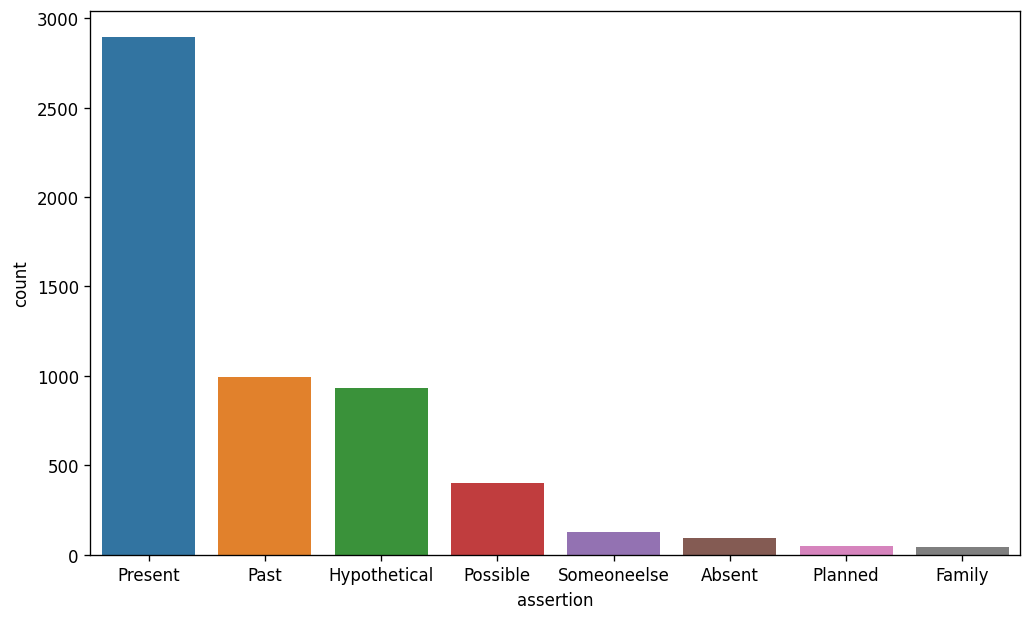

<AxesSubplot:xlabel='assertion', ylabel='count'>

In [0]:
plt.figure(figsize=[10,6], dpi=120)
sns.countplot(x="assertion", data=as_result_df, order=as_result_df.assertion.value_counts().index)

## 3.1 Use Case: Conversation Counts by DRUG & ADE Entities
**We will work with the ADE entities by droping the assertion status is `absent`.**

In [0]:
as_result_df.shape

Out[42]: (5530, 6)

In [0]:
final_ade_df = as_result_df[as_result_df.assertion != 'Absent']
final_ade_df.chunk = final_ade_df.chunk.str.lower()

final_ade_df.shape

Out[43]: (5439, 6)

**We will find the most frequent `ADE` and `DRUG` entities, then plot them on a chart to show the count of distinct conversations that contains these entities.**

In [0]:
most_common_ade = final_ade_df.chunk.value_counts().index[:20]
most_common_ade

Out[44]: Index(['fever', 'thrombocytopenia', 'neurotoxicity', 'seizures',
 'hepatotoxicity', 'acute renal failure', 'rhabdomyolysis',
 'agranulocytosis', 'pneumonitis', 'pulmonary toxicity', 'hepatitis',
 'nephrotic syndrome', 'acute pancreatitis', 'leukopenia', 'akathisia',
 'toxic epidermal necrolysis', 'toxicity', 'hypersensitivity',
 'anaphylaxis', 'hypersensitivity syndrome'],
 dtype='object')

In [0]:
import plotly.express as px

unique_ade = final_ade_df[final_ade_df.chunk.isin(most_common_ade)].rename(columns={"chunk":"ade"}).groupby(['id','ade']).count().reset_index()[['id', 'ade']]

data=unique_ade.ade.value_counts().head(20)
data_pdf=pd.DataFrame({"Count":data.values,'ADE':data.index})
fig = px.bar(data_pdf, y='ADE', x='Count',orientation='h',color='Count', 
             color_continuous_scale=px.colors.sequential.Bluyl, width=1200, height=700) 

fig.update_layout(
    title={
        'text': "Unique Conversation Counts by ADE",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center'
        },
    font=dict(size=15))

fig.show()

In [0]:
most_common_drug = drug_df.chunk.value_counts().index[:20]
most_common_drug

Out[46]: Index(['methotrexate', 'lithium', 'chemotherapy', 'carbamazepine',
 '5-fluorouracil', 'amiodarone', 'olanzapine', 'clozapine',
 'cyclophosphamide', 'tamoxifen', 'infliximab', 'phenytoin', 'cisplatin',
 'cyclosporine', 'bleomycin', 'risperidone', 'ethambutol', 'insulin',
 'rituximab', 'gemcitabine'],
 dtype='object')

In [0]:
import plotly.express as px

unique_drug = drug_df[drug_df.chunk.isin(most_common_drug)].rename(columns={"chunk":"drug"}).groupby(['id','drug']).count().reset_index()[['id', 'drug']]

data=unique_drug.drug.value_counts().head(20)
data_pdf=pd.DataFrame({"Count":data.values,'ADE':data.index})
fig = px.bar(data_pdf, y='ADE', x='Count',orientation='h',color='Count', 
             color_continuous_scale=px.colors.sequential.Bluyl, width=1200, height=700) 

fig.update_layout(
    title={
        'text': "Unique Conversation Counts by DRUG",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center'
        },
    font=dict(size=15))

fig.show()

## 3.2 Use Case: Most Common ADE-DRUG Pairs 
**We can find the most common ADE-DRUG pairs that were talked in the same conversation.**

In [0]:
top_20_ade = unique_ade.groupby("ade").count().sort_values(by="id", ascending=False).iloc[:20].index
top_20_drug = unique_drug.groupby("drug").count().sort_values(by="id", ascending=False).iloc[:20].index

In [0]:
merged_df = pd.merge(unique_ade[unique_ade.ade.isin(top_20_ade)],
                     unique_drug[unique_drug.drug.isin(top_20_drug)],
                     on = "id").groupby(["ade", "drug"]).count().reset_index()

drug_ade_df = merged_df.pivot_table(index="ade", columns=["drug"], values="id", fill_value=0)
drug_ade_df

Out[49]:

drug,5-fluorouracil,amiodarone,bleomycin,carbamazepine,chemotherapy,cisplatin,clozapine,cyclophosphamide,cyclosporine,ethambutol,infliximab,insulin,lithium,methotrexate,olanzapine,phenytoin,risperidone,rituximab
ade,,,,,,,,,,,,,,,,,,
acute pancreatitis,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
acute renal failure,0,0,0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0
agranulocytosis,0,0,0,0,0,0,7,0,0,0,1,0,0,0,2,0,0,0
akathisia,0,0,0,0,0,0,1,0,0,0,0,0,1,0,2,0,1,0
anaphylaxis,0,0,0,0,0,2,0,0,1,0,0,0,0,3,0,0,0,0
fever,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,3,0,0
hepatitis,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,1,0,0
hepatotoxicity,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
hypersensitivity,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0


In [0]:
import plotly.express as px

fig = px.imshow(drug_ade_df,labels=dict(x="DRUG", y="ADE", color='Occurence'),y=list(drug_ade_df.index), 
                x=list(drug_ade_df.columns), color_continuous_scale=px.colors.sequential.Mint)

fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    title={
        'text': "Number of Conversation",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center'
        },
    font=dict(size=15))

fig.show()

**As you can see in the results, Pneumonitis-Methotrexate is the most common `ADE-DRUG` pair.**

# 4. Analyze Relations Between ADE & DRUG Entities

## 4.1. Use Case: Extract Relations Between ADE and DRUG Entities

We can extract the relations between `ADE` and `DRUG` entities by using `re_ade_clinical` model. We won't use `SentenceDetector` annotator in this pipeline to check the relations between entities in difference sentences.

In [0]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")
  
ade_ner = medical.NerModel.pretrained("ner_ade_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_converter = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")

pos_tagger = nlp.PerceptronModel.pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")    

dependency_parser = nlp.DependencyParserModel.pretrained("dependency_conllu", "en")\
    .setInputCols(["sentence", "pos_tags", "token"])\
    .setOutputCol("dependencies")

reModel = medical.RelationExtractionModel.pretrained("re_ade_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunk", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(0)\
    .setRelationPairs(["ade-drug", "drug-ade"])


re_pipeline = nlp.Pipeline(stages=[
    documentAssembler, 
    tokenizer,
    word_embeddings,
    ade_ner,
    ner_converter,
    pos_tagger,
    dependency_parser,
    reModel
])


empty_data = spark.createDataFrame([[""]]).toDF("text")
re_model = re_pipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
ner_ade_clinical download started this may take some time.
[ | ][OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[ | ][ / ][OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][OK!]
re_ade_clinical download started this may take some time.
Approximate size to download 10.9 MB
[ | ][ / ][ — ][OK!]

In [0]:
re_result = re_model.transform(df)

**Now we can show our detected entities, their relations and confidence levels in a dataframe.**

In [0]:
rel_df = re_result.select('text', F.explode(F.arrays_zip(re_result.relations.result, re_result.relations.metadata)).alias("cols"))\
                   .select('text', F.expr("cols['0']").alias("relation"),
                                   F.expr("cols['1']['entity1']").alias("entity1"),
                                   F.expr("cols['1']['chunk1']").alias("chunk1"),
                                   F.expr("cols['1']['entity2']").alias("entity2"),
                                   F.expr("cols['1']['chunk2']").alias("chunk2"),
                                   F.expr("cols['1']['confidence']").alias("confidence")).toPandas()

In [0]:
rel_df.head(30)

Out[54]:

,text,relation,entity1,chunk1,entity2,chunk2,confidence
0,"In 2 of the 3 cases the patients were also taking lithium carbonate and beta-blockers, both of w...",1,DRUG,lithium carbonate,ADE,incontinence,0.9999962
1,"Anticonvulsant hypersensitivity syndrome associated with Bellamine S, a therapy for menopausal s...",1,ADE,Anticonvulsant hypersensitivity syndrome,DRUG,Bellamine S,1.0
2,"In the absence of mucositis or diarrhea, severe dermatologic toxicity following a single low dos...",1,ADE,diarrhea,DRUG,methotrexate,1.0
3,"In the absence of mucositis or diarrhea, severe dermatologic toxicity following a single low dos...",1,ADE,severe dermatologic toxicity,DRUG,methotrexate,0.99999976
4,"In the absence of mucositis or diarrhea, severe dermatologic toxicity following a single low dos...",1,ADE,acute hypersensitivity reaction,DRUG,methotrexate,1.0
5,A 53-year-old man developed NMS without rigidity while taking olanzapine.,1,ADE,NMS,DRUG,olanzapine,1.0
6,DISCUSSION: This case shows that switching to zidovudine potentially can lead to a hyperlactatem...,1,DRUG,zidovudine,ADE,hyperlactatemia,1.0
7,Bradycardia and congestive heart failure associated with ocular timolol maleate.,1,ADE,Bradycardia,DRUG,timolol maleate,0.99999976
8,Bradycardia and congestive heart failure associated with ocular timolol maleate.,1,ADE,congestive heart failure,DRUG,timolol maleate,1.0
9,Hyperglycemia and diabetic coma: possible relationship to diuretic-propranolol therapy.,1,ADE,Hyperglycemia,DRUG,diuretic-propranolol,1.0


**We will convert the chunks to lowercase to get more accurate results.**

In [0]:
rel_df.chunk1 = rel_df.chunk1.str.lower()
rel_df.chunk2 = rel_df.chunk2.str.lower()

In [0]:
rel_df.drop_duplicates(["chunk1", "chunk2"]).head(20)

Out[56]:

,text,relation,entity1,chunk1,entity2,chunk2,confidence
0,"In 2 of the 3 cases the patients were also taking lithium carbonate and beta-blockers, both of w...",1,DRUG,lithium carbonate,ADE,incontinence,0.9999962
1,"Anticonvulsant hypersensitivity syndrome associated with Bellamine S, a therapy for menopausal s...",1,ADE,anticonvulsant hypersensitivity syndrome,DRUG,bellamine s,1.0
2,"In the absence of mucositis or diarrhea, severe dermatologic toxicity following a single low dos...",1,ADE,diarrhea,DRUG,methotrexate,1.0
3,"In the absence of mucositis or diarrhea, severe dermatologic toxicity following a single low dos...",1,ADE,severe dermatologic toxicity,DRUG,methotrexate,0.99999976
4,"In the absence of mucositis or diarrhea, severe dermatologic toxicity following a single low dos...",1,ADE,acute hypersensitivity reaction,DRUG,methotrexate,1.0
5,A 53-year-old man developed NMS without rigidity while taking olanzapine.,1,ADE,nms,DRUG,olanzapine,1.0
6,DISCUSSION: This case shows that switching to zidovudine potentially can lead to a hyperlactatem...,1,DRUG,zidovudine,ADE,hyperlactatemia,1.0
7,Bradycardia and congestive heart failure associated with ocular timolol maleate.,1,ADE,bradycardia,DRUG,timolol maleate,0.99999976
8,Bradycardia and congestive heart failure associated with ocular timolol maleate.,1,ADE,congestive heart failure,DRUG,timolol maleate,1.0
9,Hyperglycemia and diabetic coma: possible relationship to diuretic-propranolol therapy.,1,ADE,hyperglycemia,DRUG,diuretic-propranolol,1.0


**We can show only `ADE-DRUG` in relation pairs.**

In [0]:
in_relation_df = rel_df[rel_df.relation.astype(int) == 1].drop_duplicates().reset_index(drop=True)
in_relation_df.head(20)

Out[57]:

,text,relation,entity1,chunk1,entity2,chunk2,confidence
0,"In 2 of the 3 cases the patients were also taking lithium carbonate and beta-blockers, both of w...",1,DRUG,lithium carbonate,ADE,incontinence,0.9999962
1,"Anticonvulsant hypersensitivity syndrome associated with Bellamine S, a therapy for menopausal s...",1,ADE,anticonvulsant hypersensitivity syndrome,DRUG,bellamine s,1.0
2,"In the absence of mucositis or diarrhea, severe dermatologic toxicity following a single low dos...",1,ADE,diarrhea,DRUG,methotrexate,1.0
3,"In the absence of mucositis or diarrhea, severe dermatologic toxicity following a single low dos...",1,ADE,severe dermatologic toxicity,DRUG,methotrexate,0.99999976
4,"In the absence of mucositis or diarrhea, severe dermatologic toxicity following a single low dos...",1,ADE,acute hypersensitivity reaction,DRUG,methotrexate,1.0
5,A 53-year-old man developed NMS without rigidity while taking olanzapine.,1,ADE,nms,DRUG,olanzapine,1.0
6,DISCUSSION: This case shows that switching to zidovudine potentially can lead to a hyperlactatem...,1,DRUG,zidovudine,ADE,hyperlactatemia,1.0
7,Bradycardia and congestive heart failure associated with ocular timolol maleate.,1,ADE,bradycardia,DRUG,timolol maleate,0.99999976
8,Bradycardia and congestive heart failure associated with ocular timolol maleate.,1,ADE,congestive heart failure,DRUG,timolol maleate,1.0
9,Hyperglycemia and diabetic coma: possible relationship to diuretic-propranolol therapy.,1,ADE,hyperglycemia,DRUG,diuretic-propranolol,1.0


**Show the relations on the raw text bu using `sparknlp_display` library.**

In [0]:
re_light_model = nlp.LightPipeline(re_model)
re_vis = nlp.viz.RelationExtractionVisualizer()

sample_text = df.filter(df["id"].isin([12, 34, 29, 4256, 1649])).select(["text"]).collect()

for index, text in enumerate(sample_text):

    print("\n", "*"*50, f'Sample Text {index+1}', "*"*50, "\n")
    
    re_light_result = re_light_model.fullAnnotate(text.text)

    relation_vis = re_vis.display(re_light_result[0],
                                  relation_col = 'relations',
                                  document_col = 'sentence',
                                  show_relations=True,
                                  return_html=True
                                   )
    
    displayHTML(relation_vis)

************************************************** Sample Text 1 **************************************************

Ten days after itraconazole DRUG was started, he developed paralytic ileus ADE , neurogenic bladder ADE , mild left ptosis ADE , and absence of deep reflexes ADE , with severe paralysis of the lower extremities ADE and mild weakness of the upper extremities ADE . <polyline fill="none" points="124.0,155.0 124.83673469387752,154.33673469387753 125.6734693877551,153.6734693877551 126.51020408163266,153.01020408163268 127.34693877551021,152.3469387755102 128.18367346938777,151.68367346938777 129.0204081632653,151.0204081632653 129.8571428571429,150.35714285714292 130.69387755102042,149.69387755102042 131.53061224489798,149.03061224489798 132.3673469387755,148.36734693877554 133.20408163265304,147.70408163265307 134.0408163265306,147.0408163265306 134.87755102040816,146.3775510204082 135.71428571428572,145.71428571428572 136.55102040816328,145.05102040816328 137.3877551020408,144.38775510204084 138.2244897959184,143.7244897959184 139.0612244897959,143.0612244897959 139.89795918367346,142.3979591836735 140.734693877551,141.734693877551 141.57142857142858,141.07142857142856 142.40816326530614,140.40816326530614 143.24489795918367,139.74489795918367 144.08163265306123,139.08163265306123 144.9183673469388,138.41836734693877 145.75510204081633,137.75510204081633 146.59183673469389,137.09183673469389 147.42857142857144,136.42857142857144 148.26530612244898,135.765306122449 149.10204081632654,135.10204081632654 149.9387755102041,134.4387755102041 150.77551020408163,133.77551020408163 151.6122448979592,133.11224489795921 152.44897959183675,132.44897959183675 153.28571428571428,131.7857142857143 154.12244897959187,131.12244897959184 154.9591836734694,130.4591836734694 155.79591836734696,129.79591836734693 156.6326530612245,129.13265306122452 157.46938775510205,128.46938775510205 158.3061224489796,127.80612244897961 159.14285714285717,127.14285714285717 159.9795918367347,126.4795918367347 160.81632653061223,125.81632653061226 161.6530612244898,125.15306122448982 162.48979591836735,124.48979591836735 163.3265306122449,123.8265306122449 164.16326530612247,123.16326530612245 165.0,122.5 165.0,122.5 165.83673469387753,121.83673469387755 166.6734693877551,121.17346938775509 167.51020408163265,120.51020408163266 168.3469387755102,119.84693877551021 169.18367346938774,119.18367346938776 170.0204081632653,118.5204081632653 170.8571428571429,117.85714285714289 171.69387755102042,117.19387755102042 172.530612244898,116.53061224489795 173.36734693877548,115.86734693877548 174.20408163265304,115.20408163265304 175.0408163265306,114.54081632653057 175.87755102040813,113.87755102040816 176.7142857142857,113.21428571428571 177.55102040816325,112.55102040816328 178.3877551020408,111.88775510204083 179.2244897959184,111.22448979591837 180.0612244897959,110.56122448979592 180.89795918367346,109.89795918367346 181.734693877551,109.23469387755101 182.57142857142856,108.57142857142856 183.40816326530611,107.90816326530613 184.24489795918365,107.24489795918367 185.0816326530612,106.58163265306122 185.91836734693877,105.91836734693875 186.7551020408163,105.25510204081633 187.59183673469386,104.59183673469387 188.42857142857144,103.92857142857144 189.26530612244898,103.26530612244898 190.1020408163265,102.60204081632654 190.9387755102041,101.9387755102041 191.7755102040816,101.27551020408163 192.61224489795916,100.61224489795917 193.4489795918367,99.94897959183672 194.28571428571428,99.28571428571428 195.1224489795918,98.62244897959184 195.9591836734694,97.9591836734694 196.79591836734693,97.29591836734693 197.6326530612245,96.63265306122449 198.46938775510205,95.96938775510205 199.30612244897958,95.3061224489796 200.14285714285714,94.64285714285714 200.9795918367347,93.9795918367347 201.81632653061223,93.31632653061224 202.6530612244898,92.6530612244898 203.48979591836732,91.98979591836735 204.32653061224488,91.3265306122449 205.16326530612244,90.66326530612244 206.0,90.0" stroke="#6e5772" stroke-width="1" /> 1 <polyline fill="none" points="221.0,255.0 220.8979591

************************************************** Sample Text 2 **************************************************

The observations suggest that testicular swelling ADE and pain ADE are side effects of desipramine DRUG . <polyline fill="none" points="897.0,55.0 894.0204081632652,53.79607986468223 891.0408163265305,52.593128713376224 888.0612244897959,51.39211553009376 885.0816326530612,50.194009298846574 882.1020408163265,48.999779003646445 879.1224489795917,47.810393628505125 876.1428571428573,46.626822157434425 873.1632653061228,45.450033574446024 870.1836734693878,44.280996863551756 867.204081632653,43.12068100876335 864.2244897959184,41.97005499409259 861.2448979591835,40.83008780355124 858.2653061224489,39.70174842115105 855.2857142857143,38.586005830903794 852.3061224489797,37.48382901682123 849.3265306122449,36.396186962915124 846.3469387755104,35.32404865319723 843.3673469387755,34.26838307167932 840.387755102041,33.23015920237316 837.408163265306,32.21034602929051 834.4285714285714,31.209912536443145 831.4489795918367,30.229827707842823 828.469387755102,29.271060527501298 825.4897959183676,28.334579979430348 822.5102040816327,27.421355047641715 819.530612244898,26.532354716147186 816.5510204081634,25.668547968958514 813.5714285714287,24.83090379008747 810.5918367346939,24.020391163545803 807.6122448979593,23.237979073345294 804.6326530612247,22.484636503497697 801.6530612244899,21.761332438014776 798.6734693877552,21.069035860908297 795.6938775510205,20.408715756190023 792.7142857142858,19.781341107871725 789.7346938775511,19.187880899965155 786.7551020408164,18.629304116482082 783.7755102040817,18.106579741434267 780.795918367347,17.620676758833483 777.8163265306123,17.172564152691482 774.8367346938776,16.76321090702004 771.8571428571429,16.393586005830905 768.8775510204082,16.064658433135854 765.8979591836735,15.77739717294665 762.9183673469388,15.53277120927505 759.9387755102041,15.33174952613282 756.9591836734694,15.175301107531727 753.9795918367347,15.064394937483533 751.0,15.0 751.0,15.0 748.0204081632653,14.982762284422305 745.0408163265305,15.012035801409274 742.0612244897959,15.086851566949145 739.0816326530612,15.20624059703015 736.1020408163264,15.369233907640522 733.1224489795917,15.574862514768505 730.1428571428572,15.822157434402333 727.1632653061225,16.11014968253024 724.1836734693877,16.43787027514046 721.2040816326529,16.80435022822123 718.2244897959182,17.208620557760792 715.2448979591835,17.64971227974738 712.2653061224488,18.126656410169232 709.2857142857142,18.638483965014576 706.3061224489796,19.184225960271654 703.3265306122448,19.762913411928704 700.3469387755102,20.37357733597396 697.3673469387755,21.01524874839565 694.3877551020407,21.686958665182026 691.4081632653059,22.387738102321304 688.4285714285713,23.116618075801746 685.4489795918366,23.87262960161157 682.4693877551019,24.654803695739016 679.4897959183673,25.462171374172325 676.5102040816327,26.293763652899724 673.5306122448978,27.148611547909454 670.5510204081633,28.02574607518976 667.5714285714286,28.92419825072886 664.5918367346939,29.842999090515008 661.6122448979592,30.78117961053642 658.6326530612245,31.737770826781354 655.6530612244898,32.71180375523804 652.6734693877551,33.7023094118947 649.6938775510204,34.70831881273959 646.7142857142858,35.728862973760926 643.7346938775511,36.762972910946964 640.7551020408164,37.809679640285935 637.7755102040816,38.868014177766064 634.795918367347,39.93700753937559 631.8163265306123,41.015690741102766 628.8367346938776,42.103094798935814 625.8571428571429,43.19825072886297 622.8775510204081,44.300189546872474 619.8979591836735,45.40794226895255 616.9183673469388,46.52053991109146 613.9387755102041,47.63701348927743 610.9591836734694,48.75639401949867 607.9795918367347,49.877712517743454 605.0,51.0" stroke="#6e5772" stroke-width="1" /> 1 <polyline fill="none" points="902.0,55.0 897.1326530612243,53.79607986468223 892.2653061224488,52.593128713376224 887.3979591836735,51.39211553009376 882.5306122448981,50.194009298846574 877.6632653061224,48.999779003646445 872.7959183673469,47.810393628505125 867.9285714

************************************************** Sample Text 3 **************************************************

The patient experienced muscle twitches ADE , tremulousness ADE , and anxiety ADE on day 17 of foscarnet DRUG therapy. <polyline fill="none" points="66.0,155.0 68.48979591836734,154.33673469387753 70.97959183673468,153.6734693877551 73.46938775510206,153.01020408163268 75.95918367346938,152.3469387755102 78.44897959183673,151.68367346938777 80.93877551020408,151.0204081632653 83.42857142857144,150.35714285714292 85.9183673469388,149.69387755102042 88.40816326530614,149.03061224489798 90.89795918367345,148.36734693877554 93.3877551020408,147.70408163265307 95.87755102040815,147.0408163265306 98.3673469387755,146.3775510204082 100.85714285714288,145.71428571428572 103.34693877551021,145.05102040816328 105.83673469387755,144.38775510204084 108.32653061224491,143.7244897959184 110.81632653061224,143.0612244897959 113.30612244897961,142.3979591836735 115.79591836734691,141.734693877551 118.28571428571426,141.07142857142856 120.77551020408164,140.40816326530614 123.26530612244898,139.74489795918367 125.75510204081633,139.08163265306123 128.24489795918367,138.41836734693877 130.734693877551,137.75510204081633 133.22448979591837,137.09183673469389 135.71428571428572,136.42857142857144 138.20408163265307,135.765306122449 140.6938775510204,135.10204081632654 143.18367346938777,134.4387755102041 145.6734693877551,133.77551020408163 148.16326530612247,133.11224489795921 150.6530612244898,132.44897959183675 153.14285714285714,131.7857142857143 155.6326530612245,131.12244897959184 158.12244897959184,130.4591836734694 160.6122448979592,129.79591836734693 163.1020408163265,129.13265306122452 165.59183673469386,128.46938775510205 168.0816326530612,127.80612244897961 170.57142857142858,127.14285714285717 173.0612244897959,126.4795918367347 175.55102040816325,125.81632653061226 178.0408163265306,125.15306122448982 180.53061224489795,124.48979591836735 183.0204081632653,123.8265306122449 185.51020408163265,123.16326530612245 188.0,122.5 188.0,122.5 190.48979591836735,121.83673469387755 192.97959183673467,121.17346938775509 195.46938775510205,120.51020408163266 197.95918367346937,119.84693877551021 200.44897959183672,119.18367346938776 202.93877551020407,118.5204081632653 205.42857142857147,117.85714285714289 207.9183673469388,117.19387755102042 210.40816326530614,116.53061224489795 212.89795918367344,115.86734693877548 215.38775510204079,115.20408163265304 217.87755102040813,114.54081632653057 220.36734693877548,113.87755102040816 222.85714285714283,113.21428571428571 225.3469387755102,112.55102040816328 227.83673469387753,111.88775510204083 230.3265306122449,111.22448979591837 232.8163265306122,110.56122448979592 235.3061224489796,109.89795918367346 237.7959183673469,109.23469387755101 240.28571428571428,108.57142857142856 242.7755102040816,107.90816326530613 245.26530612244892,107.24489795918367 247.75510204081633,106.58163265306122 250.24489795918367,105.91836734693875 252.73469387755097,105.25510204081633 255.22448979591832,104.59183673469387 257.7142857142857,103.92857142857144 260.2040816326531,103.26530612244898 262.69387755102036,102.60204081632654 265.18367346938777,101.9387755102041 267.67346938775506,101.27551020408163 270.1632653061224,100.61224489795917 272.65306122448976,99.94897959183672 275.1428571428571,99.28571428571428 277.63265306122446,98.62244897959184 280.1224489795918,97.9591836734694 282.61224489795916,97.29591836734693 285.1020408163265,96.63265306122449 287.59183673469386,95.96938775510205 290.0816326530612,95.3061224489796 292.57142857142856,94.64285714285714 295.0612244897959,93.9795918367347 297.55102040816325,93.31632653061224 300.0408163265306,92.6530612244898 302.53061224489795,91.98979591836735 305.0204081632653,91.3265306122449 307.51020408163265,90.66326530612244 310.0,90.0" stroke="#6e5772" stroke-width="1" /> 1 <polyline fill="none" points="61.0,155.0 65.42857142857143,154.33673469387753 69.85714285714285,153.6734693877551 74.28571428571429,153.01020408163268 78.71428571428572,152.3469387755102 83.14285714285

************************************************** Sample Text 4 **************************************************

During her third cycle, she again received cisplatin DRUG 100 mg/m2 over 30 minutes and developed palmar pruritus ADE , urticaria ADE , and edema ADE . <polyline fill="none" points="421.0,155.0 421.63265306122446,154.33673469387753 422.265306122449,153.6734693877551 422.8979591836735,153.01020408163268 423.53061224489795,152.3469387755102 424.16326530612247,151.68367346938777 424.7959183673469,151.0204081632653 425.42857142857156,150.35714285714292 426.061224489796,149.69387755102042 426.6938775510204,149.03061224489798 427.3265306122449,148.36734693877554 427.9591836734694,147.70408163265307 428.59183673469386,147.0408163265306 429.2244897959184,146.3775510204082 429.8571428571429,145.71428571428572 430.4897959183674,145.05102040816328 431.12244897959187,144.38775510204084 431.7551020408164,143.7244897959184 432.38775510204084,143.0612244897959 433.0204081632653,142.3979591836735 433.65306122448976,141.734693877551 434.28571428571433,141.07142857142856 434.91836734693885,140.40816326530614 435.55102040816325,139.74489795918367 436.1836734693878,139.08163265306123 436.8163265306123,138.41836734693877 437.44897959183675,137.75510204081633 438.0816326530613,137.09183673469389 438.7142857142858,136.42857142857144 439.34693877551024,135.765306122449 439.9795918367347,135.10204081632654 440.6122448979592,134.4387755102041 441.2448979591837,133.77551020408163 441.8775510204082,133.11224489795921 442.51020408163265,132.44897959183675 443.14285714285717,131.7857142857143 443.7755102040817,131.12244897959184 444.40816326530614,130.4591836734694 445.0408163265306,129.79591836734693 445.6734693877552,129.13265306122452 446.3061224489796,128.46938775510205 446.9387755102041,127.80612244897961 447.57142857142867,127.14285714285717 448.2040816326531,126.4795918367347 448.83673469387753,125.81632653061226 449.46938775510205,125.15306122448982 450.10204081632656,124.48979591836735 450.734693877551,123.8265306122449 451.36734693877554,123.16326530612245 452.0,122.5 452.0,122.5 452.63265306122446,121.83673469387755 453.26530612244886,121.17346938775509 453.8979591836735,120.51020408163266 454.530612244898,119.84693877551021 455.16326530612247,119.18367346938776 455.79591836734687,118.5204081632653 456.42857142857156,117.85714285714289 457.061224489796,117.19387755102042 457.6938775510205,116.53061224489795 458.3265306122448,115.86734693877548 458.95918367346934,115.20408163265304 459.5918367346938,114.54081632653057 460.2244897959184,113.87755102040816 460.85714285714283,113.21428571428571 461.4897959183674,112.55102040816328 462.12244897959187,111.88775510204083 462.7551020408164,111.22448979591837 463.3877551020408,110.56122448979592 464.02040816326524,109.89795918367346 464.65306122448965,109.23469387755101 465.2857142857142,108.57142857142856 465.91836734693874,107.90816326530613 466.55102040816325,107.24489795918367 467.18367346938777,106.58163265306122 467.81632653061223,105.91836734693875 468.4489795918367,105.25510204081633 469.0816326530612,104.59183673469387 469.7142857142857,103.92857142857144 470.3469387755102,103.26530612244898 470.9795918367347,102.60204081632654 471.6122448979592,101.9387755102041 472.2448979591836,101.27551020408163 472.8775510204081,100.61224489795917 473.51020408163265,99.94897959183672 474.14285714285717,99.28571428571428 474.7755102040816,98.62244897959184 475.40816326530614,97.9591836734694 476.0408163265306,97.29591836734693 476.67346938775506,96.63265306122449 477.3061224489796,95.96938775510205 477.9387755102041,95.3061224489796 478.57142857142856,94.64285714285714 479.204081632653,93.9795918367347 479.8367346938776,93.31632653061224 480.46938775510205,92.6530612244898 481.1020408163265,91.98979591836735 481.734693877551,91.3265306122449 482.3673469387755,90.66326530612244 483.0,90.0" stroke="#6e5772" stroke-width="1" /> 1 <polyline fill="none" points="260.0,155.0 262.3265306122449,154.33673469387753 264.65306122448976,153.6734693877551 266.9795918367347,153.01020408163268 269.3061224489796,152.346938775

************************************************** Sample Text 5 **************************************************

Dyspnea ADE , hypoxemia ADE , and pleuritic chest pain ADE occurred within 24 hours of rituximab DRUG administration, and there was no other apparent explanation. <polyline fill="none" points="873.0,55.0 868.4897959183671,53.79607986468223 863.9795918367346,52.593128713376224 859.4693877551022,51.39211553009376 854.9591836734694,50.194009298846574 850.4489795918367,48.999779003646445 845.938775510204,47.810393628505125 841.4285714285716,46.626822157434425 836.9183673469389,45.450033574446024 832.4081632653061,44.280996863551756 827.8979591836734,43.12068100876335 823.3877551020407,41.97005499409259 818.877551020408,40.83008780355124 814.3673469387754,39.70174842115105 809.8571428571429,38.586005830903794 805.3469387755105,37.48382901682123 800.8367346938776,36.396186962915124 796.3265306122452,35.32404865319723 791.8163265306123,34.26838307167932 787.3061224489796,33.23015920237316 782.7959183673469,32.21034602929051 778.2857142857142,31.209912536443145 773.7755102040817,30.229827707842823 769.265306122449,29.271060527501298 764.7551020408164,28.334579979430348 760.2448979591838,27.421355047641715 755.734693877551,26.532354716147186 751.2244897959184,25.668547968958514 746.7142857142858,24.83090379008747 742.2040816326531,24.020391163545803 737.6938775510205,23.237979073345294 733.1836734693879,22.484636503497697 728.6734693877551,21.761332438014776 724.1632653061224,21.069035860908297 719.6530612244899,20.408715756190023 715.1428571428573,19.781341107871725 710.6326530612246,19.187880899965155 706.1224489795919,18.629304116482082 701.6122448979593,18.106579741434267 697.1020408163265,17.620676758833483 692.591836734694,17.172564152691482 688.0816326530612,16.76321090702004 683.5714285714287,16.393586005830905 679.0612244897959,16.064658433135854 674.5510204081634,15.77739717294665 670.0408163265306,15.53277120927505 665.5306122448981,15.33174952613282 661.0204081632653,15.175301107531727 656.5102040816327,15.064394937483533 652.0,15.0 652.0,15.0 647.4897959183673,14.982762284422305 642.9795918367347,15.012035801409274 638.469387755102,15.086851566949145 633.9591836734693,15.20624059703015 629.4489795918367,15.369233907640522 624.9387755102041,15.574862514768505 620.4285714285716,15.822157434402333 615.9183673469388,16.11014968253024 611.4081632653061,16.43787027514046 606.8979591836734,16.80435022822123 602.3877551020407,17.208620557760792 597.877551020408,17.64971227974738 593.3673469387754,18.126656410169232 588.8571428571428,18.638483965014576 584.3469387755102,19.184225960271654 579.8367346938776,19.762913411928704 575.3265306122449,20.37357733597396 570.8163265306122,21.01524874839565 566.3061224489795,21.686958665182026 561.7959183673468,22.387738102321304 557.2857142857142,23.116618075801746 552.7755102040816,23.87262960161157 548.2653061224489,24.654803695739016 543.7551020408163,25.462171374172325 539.2448979591836,26.293763652899724 534.734693877551,27.148611547909454 530.2244897959183,28.02574607518976 525.7142857142858,28.92419825072886 521.204081632653,29.842999090515008 516.6938775510205,30.78117961053642 512.1836734693877,31.737770826781354 507.67346938775506,32.71180375523804 503.1632653061224,33.7023094118947 498.65306122448976,34.70831881273959 494.1428571428571,35.728862973760926 489.63265306122446,36.762972910946964 485.1224489795918,37.809679640285935 480.61224489795916,38.868014177766064 476.10204081632656,39.93700753937559 471.59183673469386,41.015690741102766 467.0816326530612,42.103094798935814 462.5714285714286,43.19825072886297 458.06122448979585,44.300189546872474 453.55102040816325,45.40794226895255 449.0408163265306,46.52053991109146 444.53061224489795,47.63701348927743 440.0204081632653,48.75639401949867 435.51020408163265,49.877712517743454 431.0,51.0" stroke="#6e5772" stroke-width="1" /> 1 <polyline fill="none" points="878.0,55.0 871.0510204081631,53.79607986468223 864.1020408163264,52.593128713376224 857.1530612244899,51.39211553009376 850.204081632653,50.194009298846574 843.2551020408164,48.

## License
Copyright / License info of the notebook. Copyright [2021] the Notebook Authors.  The source in this notebook is provided subject to the [Apache 2.0 License](https://spdx.org/licenses/Apache-2.0.html).  All included or referenced third party libraries are subject to the licenses set forth below.

|Library Name|Library License|Library License URL|Library Source URL|
| :-: | :-:| :-: | :-:|
|Pandas |BSD 3-Clause License| https://github.com/pandas-dev/pandas/blob/master/LICENSE | https://github.com/pandas-dev/pandas|
|Numpy |BSD 3-Clause License| https://github.com/numpy/numpy/blob/main/LICENSE.txt | https://github.com/numpy/numpy|
|Apache Spark |Apache License 2.0| https://github.com/apache/spark/blob/master/LICENSE | https://github.com/apache/spark/tree/master/python/pyspark|
|MatPlotLib | | https://github.com/matplotlib/matplotlib/blob/master/LICENSE/LICENSE | https://github.com/matplotlib/matplotlib|
|Seaborn |BSD 3-Clause License | https://github.com/seaborn/seaborn/blob/master/LICENSE | https://github.com/seaborn/seaborn/|
|Plotly|MIT License|https://github.com/plotly/plotly.py/blob/master/LICENSE.txt|https://github.com/plotly/plotly.py|
|Spark NLP Display|Apache License 2.0|https://github.com/JohnSnowLabs/spark-nlp-display/blob/main/LICENSE|https://github.com/JohnSnowLabs/spark-nlp-display|
|Spark NLP |Apache License 2.0| https://github.com/JohnSnowLabs/spark-nlp/blob/master/LICENSE | https://github.com/JohnSnowLabs/spark-nlp|
|Spark NLP for Healthcare|[Proprietary license - John Snow Labs Inc.](https://www.johnsnowlabs.com/spark-nlp-health/) |NA|NA|


|Author|
|-|
|Databricks Inc.|
|John Snow Labs Inc.|

## Disclaimers
Databricks Inc. (“Databricks”) does not dispense medical, diagnosis, or treatment advice. This Solution Accelerator (“tool”) is for informational purposes only and may not be used as a substitute for professional medical advice, treatment, or diagnosis. This tool may not be used within Databricks to process Protected Health Information (“PHI”) as defined in the Health Insurance Portability and Accountability Act of 1996, unless you have executed with Databricks a contract that allows for processing PHI, an accompanying Business Associate Agreement (BAA), and are running this notebook within a HIPAA Account.  Please note that if you run this notebook within Azure Databricks, your contract with Microsoft applies.